In [1]:
from datetime import datetime, timedelta, timezone
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pytz
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from twitter_fetcher.tweet_features import TweetFeatures

## Context

\@RDT contracts are Wednesday noon eastern to Wednesday noon eastern

### Parse CSV data

In [2]:
features_filename = "master_features_v2.csv"
features_df = pd.read_csv(
    features_filename,
    parse_dates=['created_at', 'eastern_time'],
    header=0)

# parse datetime strings
# fmt = "%a %b %d %H:%M:%S %z %Y"
# eastern_tz = pytz.timezone('US/Eastern')
# utc_tz = pytz.utc
# features_df['created_at'] = features_df['created_at'].apply(lambda dt: dt.tz_localize(utc_tz))
# features_df['eastern_time'] = features_df['eastern_time'].apply(lambda dt: dt.tz_localise(eastern_tz))

# set the created_at column (the UTC timezone) as the index column
features_df = features_df.set_index('created_at')
features_df = features_df.sort_index()

In [3]:
features_df.head()

,id,eastern_time,day_of_week,source,is_retweet,text_len
created_at,,,,,,
2019-07-06 12:11:18+00:00,1147478123593785344,2019-07-06 08:11:18-04:00,Saturday,"<a href=""http://twitter.com/download/iphone"" r...",False,87
2019-07-06 12:11:34+00:00,1147478190857818112,2019-07-06 08:11:34-04:00,Saturday,"<a href=""http://twitter.com/download/iphone"" r...",True,38
2019-07-06 12:12:57+00:00,1147478539320643584,2019-07-06 08:12:57-04:00,Saturday,"<a href=""http://twitter.com/download/iphone"" r...",True,144
2019-07-06 12:13:19+00:00,1147478632732024833,2019-07-06 08:13:19-04:00,Saturday,"<a href=""http://twitter.com/download/iphone"" r...",True,140
2019-07-06 12:13:25+00:00,1147478654458454016,2019-07-06 08:13:25-04:00,Saturday,"<a href=""http://twitter.com/download/iphone"" r...",True,68


In [4]:
features_df.index

DatetimeIndex(['2019-07-06 12:11:18+00:00', '2019-07-06 12:11:34+00:00',
               '2019-07-06 12:12:57+00:00', '2019-07-06 12:13:19+00:00',
               '2019-07-06 12:13:25+00:00', '2019-07-06 12:17:46+00:00',
               '2019-07-06 12:21:26+00:00', '2019-07-06 12:33:07+00:00',
               '2019-07-06 12:34:53+00:00', '2019-07-06 12:35:52+00:00',
               ...
               '2020-04-23 23:35:48+00:00', '2020-04-23 23:54:54+00:00',
               '2020-04-24 04:17:52+00:00', '2020-04-24 04:18:10+00:00',
               '2020-04-24 04:20:37+00:00', '2020-04-24 04:27:46+00:00',
               '2020-04-24 04:28:01+00:00', '2020-04-24 04:28:43+00:00',
               '2020-04-24 04:29:53+00:00', '2020-04-24 04:30:24+00:00'],
              dtype='datetime64[ns, UTC]', name='created_at', length=8200, freq=None)

### Add contract end timestamps as columns

In [5]:
eastern_tz = pytz.timezone('US/Eastern')

def contract_start_utc(created_utc_ts):
    contract_end_utc_dt = contract_end_utc(created_utc_ts)
    naive_dt = contract_end_utc_dt.replace(tzinfo=None)
    last_week = naive_dt - timedelta(days=7)
    return pytz.utc.localize(last_week)

def contract_end_utc(created_utc_ts):
    # parse_dates option when parsing the CSV into dataframe converts the date time strings to 
    # pandas Timestamp objects instead of datetime objects
    created_utc = created_utc_ts.to_pydatetime()
    created_utc = created_utc.replace(tzinfo=pytz.utc)
    
    fmt = "%a %b %d %H:%M:%S %z %Y"
    log = False
#     if created_utc.weekday() == 2:
#         log = True
#         print("timestamp =", created_utc_ts)
#         print("to_pydatetime =", created_utc)
#         print("pydatetime tzinfo =", created_utc.tzinfo)

    # first convert UTC to eastern (since the contract end time is in eastern time)
    created_eastern = created_utc.astimezone(eastern_tz)
    if log:
        print(f"UTC time {datetime.strftime(created_utc, fmt)} -> eastern time {datetime.strftime(created_eastern, fmt)}")
    
    # replace the timezone-aware datetime with a naive datetime, 
    # then localize back into eastern timezone using pytz to get the right tzinfo
    naive_dt = created_eastern.replace(tzinfo=None)
    created_datetime = eastern_tz.localize(naive_dt)

    # if the time is before noon on wednesday, then don't go to next week
    if created_datetime.weekday() == 2 and created_datetime.hour < 12:
        contract_end = created_datetime.replace(hour=12, minute=0, second=0)
    else:
        days_til_wednesday = (7 - (created_datetime.weekday() - 2)) % 7
        if created_datetime.weekday() == 2: 
            days_til_wednesday = 7
        
        naive_dt = created_datetime.replace(tzinfo=None)
        on_wednesday = naive_dt + timedelta(days=days_til_wednesday)
        noon_wednesday = on_wednesday.replace(hour=12, minute=0, second=0)
        
        contract_end = eastern_tz.localize(noon_wednesday)
    
    if log:
        print(f"contract end time (eastern) {datetime.strftime(contract_end, fmt)}")
    
    return contract_end.astimezone(pytz.utc)

In [6]:
features_df['contract_end_utc'] = features_df.index.to_series().apply(contract_end_utc)
features_df['contract_start_utc'] = features_df.index.to_series().apply(contract_start_utc)

features_df['contract_end_eastern'] = features_df['contract_end_utc'].apply(lambda dt: dt.astimezone(eastern_tz))

C:\Users\dashu\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:1: FutureWarning: The default of the 'keep_tz' keyword will change to True in a future release. You can set 'keep_tz=True' to obtain the future behaviour and silence this warning.
  """Entry point for launching an IPython kernel.
C:\Users\dashu\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:2: FutureWarning: The default of the 'keep_tz' keyword will change to True in a future release. You can set 'keep_tz=True' to obtain the future behaviour and silence this warning.
  


In [7]:
features_df

,id,eastern_time,day_of_week,source,is_retweet,text_len,contract_end_utc,contract_start_utc,contract_end_eastern
created_at,,,,,,,,,
2019-07-06 12:11:18+00:00,1147478123593785344,2019-07-06 08:11:18-04:00,Saturday,"<a href=""http://twitter.com/download/iphone"" r...",False,87,2019-07-10 16:00:00+00:00,2019-07-03 16:00:00+00:00,2019-07-10 12:00:00-04:00
2019-07-06 12:11:34+00:00,1147478190857818112,2019-07-06 08:11:34-04:00,Saturday,"<a href=""http://twitter.com/download/iphone"" r...",True,38,2019-07-10 16:00:00+00:00,2019-07-03 16:00:00+00:00,2019-07-10 12:00:00-04:00
2019-07-06 12:12:57+00:00,1147478539320643584,2019-07-06 08:12:57-04:00,Saturday,"<a href=""http://twitter.com/download/iphone"" r...",True,144,2019-07-10 16:00:00+00:00,2019-07-03 16:00:00+00:00,2019-07-10 12:00:00-04:00
2019-07-06 12:13:19+00:00,1147478632732024833,2019-07-06 08:13:19-04:00,Saturday,"<a href=""http://twitter.com/download/iphone"" r...",True,140,2019-07-10 16:00:00+00:00,2019-07-03 16:00:00+00:00,2019-07-10 12:00:00-04:00
2019-07-06 12:13:25+00:00,1147478654458454016,2019-07-06 08:13:25-04:00,Saturday,"<a href=""http://twitter.com/download/iphone"" r...",True,68,2019-07-10 16:00:00+00:00,2019-07-03 16:00:00+00:00,2019-07-10 12:00:00-04:00
2019-07-06 12:17:46+00:00,1147479750379745282,2019-07-06 08:17:46-04:00,Saturday,"<a href=""http://twitter.com/download/iphone"" r...",False,144,2019-07-10 16:00:00+00:00,2019-07-03 16:00:00+00:00,2019-07-10 12:00:00-04:00
2019-07-06 12:21:26+00:00,1147480674670174210,2019-07-06 08:21:26-04:00,Saturday,"<a href=""http://twitter.com/download/iphone"" r...",False,95,2019-07-10 16:00:00+00:00,2019-07-03 16:00:00+00:00,2019-07-10 12:00:00-04:00
2019-07-06 12:33:07+00:00,1147483613367361539,2019-07-06 08:33:07-04:00,Saturday,"<a href=""http://twitter.com/download/iphone"" r...",False,47,2019-07-10 16:00:00+00:00,2019-07-03 16:00:00+00:00,2019-07-10 12:00:00-04:00
2019-07-06 12:34:53+00:00,1147484059125395457,2019-07-06 08:34:53-04:00,Saturday,"<a href=""http://twitter.com/download/iphone"" r...",False,61,2019-07-10 16:00:00+00:00,2019-07-03 16:00:00+00:00,2019-07-10 12:00:00-04:00


### Remove incomplete contracts

The tweets data might not contain a complete week's worth of tweets. Remove any contracts that don't have at least one tweet before the beginning of the contract and one tweet after the end of the contract. 

In [8]:
# remove the tweets from incomplete weeks
# if there is a tweet after the contract end and before the contract start, then we should have all tweets from that week
# TODO what if we happened to get every tweet in that contract but none from the previous or subsequent contract?

contract_end_timestamps = features_df['contract_end_eastern'].drop_duplicates().tolist()

incomplete_contracts = []
for contract_end_ts in contract_end_timestamps:
    contract_start_ts = contract_end_ts - timedelta(days=7)
    if (features_df[(features_df['eastern_time'] > contract_end_ts)].empty or 
        features_df[(features_df['eastern_time'] < contract_start_ts)].empty):
        incomplete_contracts.append(contract_end_ts)

for timestamp in incomplete_contracts:
    features_df = features_df[(features_df['contract_end_eastern'] != timestamp)]

In [9]:
features_df

,id,eastern_time,day_of_week,source,is_retweet,text_len,contract_end_utc,contract_start_utc,contract_end_eastern
created_at,,,,,,,,,
2019-07-10 16:59:55+00:00,1149000308925849601,2019-07-10 12:59:55-04:00,Wednesday,"<a href=""http://twitter.com/download/iphone"" r...",False,139,2019-07-17 16:00:00+00:00,2019-07-10 16:00:00+00:00,2019-07-17 12:00:00-04:00
2019-07-10 23:19:11+00:00,1149095754822311937,2019-07-10 19:19:11-04:00,Wednesday,"<a href=""http://twitter.com/download/iphone"" r...",False,49,2019-07-17 16:00:00+00:00,2019-07-10 16:00:00+00:00,2019-07-17 12:00:00-04:00
2019-07-10 23:38:33+00:00,1149100628062474241,2019-07-10 19:38:33-04:00,Wednesday,"<a href=""http://twitter.com/download/iphone"" r...",False,140,2019-07-17 16:00:00+00:00,2019-07-10 16:00:00+00:00,2019-07-17 12:00:00-04:00
2019-07-11 00:05:42+00:00,1149107461539975168,2019-07-10 20:05:42-04:00,Wednesday,"<a href=""http://twitter.com/download/iphone"" r...",False,140,2019-07-17 16:00:00+00:00,2019-07-10 16:00:00+00:00,2019-07-17 12:00:00-04:00
2019-07-11 00:06:45+00:00,1149107725005180931,2019-07-10 20:06:45-04:00,Wednesday,"<a href=""http://twitter.com/download/iphone"" r...",False,140,2019-07-17 16:00:00+00:00,2019-07-10 16:00:00+00:00,2019-07-17 12:00:00-04:00
2019-07-11 00:06:46+00:00,1149107726565462018,2019-07-10 20:06:46-04:00,Wednesday,"<a href=""http://twitter.com/download/iphone"" r...",False,73,2019-07-17 16:00:00+00:00,2019-07-10 16:00:00+00:00,2019-07-17 12:00:00-04:00
2019-07-11 00:08:20+00:00,1149108122990063616,2019-07-10 20:08:20-04:00,Wednesday,"<a href=""http://twitter.com/download/iphone"" r...",False,53,2019-07-17 16:00:00+00:00,2019-07-10 16:00:00+00:00,2019-07-17 12:00:00-04:00
2019-07-11 00:12:27+00:00,1149109159570395137,2019-07-10 20:12:27-04:00,Wednesday,"<a href=""http://twitter.com/download/iphone"" r...",False,39,2019-07-17 16:00:00+00:00,2019-07-10 16:00:00+00:00,2019-07-17 12:00:00-04:00
2019-07-11 10:39:23+00:00,1149266929565261824,2019-07-11 06:39:23-04:00,Thursday,"<a href=""http://twitter.com/download/iphone"" r...",False,140,2019-07-17 16:00:00+00:00,2019-07-10 16:00:00+00:00,2019-07-17 12:00:00-04:00


### Group tweets by contract

In [10]:
tweets_per_week = features_df.groupby('contract_end_eastern').count()['id']
tweets_per_week

contract_end_eastern
2019-07-17 12:00:00-04:00    189
2019-07-24 12:00:00-04:00    131
2019-07-31 12:00:00-04:00    150
2019-08-07 12:00:00-04:00     95
2019-08-14 12:00:00-04:00    118
2019-08-21 12:00:00-04:00    175
2019-08-28 12:00:00-04:00    178
2019-09-04 12:00:00-04:00    197
2019-09-11 12:00:00-04:00    189
2019-09-18 12:00:00-04:00    161
2019-09-25 12:00:00-04:00    118
2019-10-02 12:00:00-04:00    243
2019-10-09 12:00:00-04:00    289
2019-10-16 12:00:00-04:00    192
2019-10-23 12:00:00-04:00    224
2019-10-30 12:00:00-04:00    195
2019-11-06 12:00:00-05:00    223
2019-11-13 12:00:00-05:00    202
2019-11-20 12:00:00-05:00    225
2019-11-27 12:00:00-05:00    191
2019-12-04 12:00:00-05:00    112
2019-12-11 12:00:00-05:00    336
2019-12-18 12:00:00-05:00    325
2019-12-25 12:00:00-05:00    190
2020-01-01 12:00:00-05:00    152
2020-01-08 12:00:00-05:00     97
2020-01-15 12:00:00-05:00    176
2020-01-22 12:00:00-05:00    217
2020-01-29 12:00:00-05:00    354
2020-02-05 12:00:00-05

In [11]:
# features_df[(features_df['contract_end_utc'] == datetime(2020, 4, 22, 16, 0, 0, tzinfo=pytz.utc))]

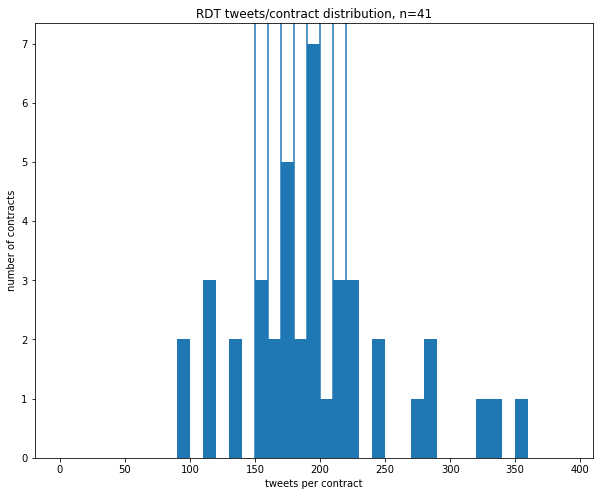

In [12]:
tweet_counts = tweets_per_week.tolist()

RDT_bins = np.arange(0, 400, 10)

fig, ax = plt.subplots(figsize=(10,8))
ax.hist(tweet_counts, RDT_bins)
# draw vertical lines to represent the contract divisions (e.g. contracts for 0-149, 150-159, ..., 210-219, 220+)
ax.axvline(150)
ax.axvline(160)
ax.axvline(170)
ax.axvline(180)
ax.axvline(190)
ax.axvline(200)
ax.axvline(210)
ax.axvline(220)
ax.set_xlabel('tweets per contract')
ax.set_ylabel('number of contracts')
ax.set_title(f"RDT tweets/contract distribution, n={len(tweet_counts)}")
plt.show()

In [13]:
np.median(tweet_counts)

191.0

In [14]:
np.mean(tweet_counts)

197.1219512195122

In [15]:
features_df.groupby('contract_end_eastern').mean()[['is_retweet', 'text_len']]

,is_retweet,text_len
contract_end_eastern,,
2019-07-17 12:00:00-04:00,0.407407,120.624339
2019-07-24 12:00:00-04:00,0.229008,119.541985
2019-07-31 12:00:00-04:00,0.140000,112.346667
2019-08-07 12:00:00-04:00,0.094737,121.631579
2019-08-14 12:00:00-04:00,0.406780,123.220339
2019-08-21 12:00:00-04:00,0.428571,115.485714
2019-08-28 12:00:00-04:00,0.337079,117.466292
2019-09-04 12:00:00-04:00,0.461929,124.832487
2019-09-11 12:00:00-04:00,0.312169,120.640212
